## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [31]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint
import random
random.seed(40)

/home/kantajit/tools/anaconda3/lib/python3.7/site-packages/spacy/util.py:1636: UserWarning:

[W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu



## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
# Opening JSON file 
f = open('complaints.json', 'r')
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


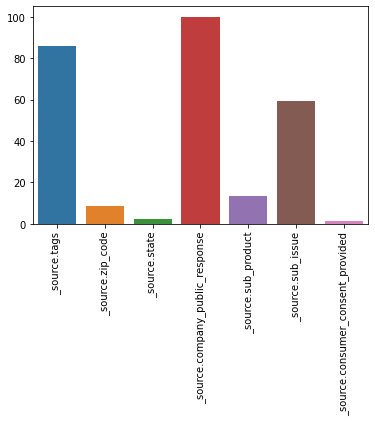

In [3]:
# Inspect the dataframe to understand the given data.
print(df.info())
missing_values = df.isna().sum()/len(df.index)*100
missing_values_perc = missing_values[missing_values!=0]
ax = sns.barplot(x = missing_values_perc.index, y = missing_values_perc.values)
ax.tick_params(axis='x', rotation=90)
df.head()


In [4]:
#print the column names
print(df.columns)

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')


In [5]:
#Assign new column names
new_cols = {col:(col[col.index('.')+1:] if col.startswith('_source') else col.strip('_')) for col in df.columns}
df = df.rename(new_cols, axis=1)
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      78313 non-null  object 
 1   type                       78313 non-null  object 
 2   id                         78313 non-null  object 
 3   score                      78313 non-null  float64
 4   tags                       10900 non-null  object 
 5   zip_code                   71556 non-null  object 
 6   complaint_id               78313 non-null  object 
 7   issue                      78313 non-null  object 
 8   date_received              78313 non-null  object 
 9   state                      76322 non-null  object 
 10  consumer_disputed          78313 non-null  object 
 11  product                    78313 non-null  object 
 12  company_response           78313 non-null  object 
 13  company                    78313 non-null  obj

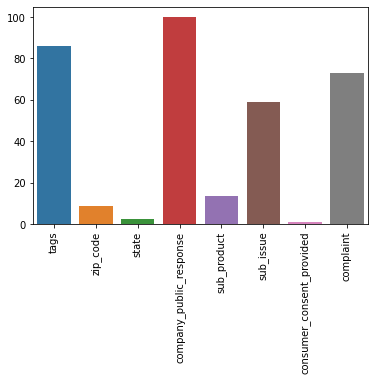

In [6]:
#Assign nan in place of blanks in the complaints column
df['complaint']= df.complaint_what_happened.apply(lambda x: np.nan if len(x)==0 else x)
missing_values = df.isna().sum()/len(df.index)*100
missing_values_perc = missing_values[missing_values!=0]
ax = sns.barplot(x = missing_values_perc.index, y = missing_values_perc.values)
ax.tick_params(axis='x', rotation=90)
print(df.info())

In [7]:
#Remove all rows where complaints column is nan
df = df[~df.complaint.isna()]
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21072 entries, 1 to 78312
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      21072 non-null  object 
 1   type                       21072 non-null  object 
 2   id                         21072 non-null  object 
 3   score                      21072 non-null  float64
 4   tags                       3816 non-null   object 
 5   zip_code                   16427 non-null  object 
 6   complaint_id               21072 non-null  object 
 7   issue                      21072 non-null  object 
 8   date_received              21072 non-null  object 
 9   state                      20929 non-null  object 
 10  consumer_disputed          21072 non-null  object 
 11  product                    21072 non-null  object 
 12  company_response           21072 non-null  object 
 13  company                    21072 non-null  obj

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


In [82]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_complaint(complaint):
    cleaned_complaint = complaint.lower()
    cleaned_complaint = re.sub('\[.*\]',' ', cleaned_complaint)
    cleaned_complaint = re.sub(f'[{string.punctuation}]',' ', cleaned_complaint,)
    cleaned_complaint = re.sub('([a-z]+[0-9]+[a-z]*|[a-z]*[0-9]+[a-z]+)','', cleaned_complaint)
    return cleaned_complaint
    
    
df['complaint_text']=df.complaint.apply(clean_complaint)

In [84]:
#Write your function to Lemmatize the texts
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

lemmatizer = WordNetLemmatizer()

def lemmatize_complaint(complaint):
    return [lemmatizer.lemmatize(token) for token in word_tokenize(complaint)]
    

In [85]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df['lemmatized_complaint'] = df.complaint_text.apply(lemmatize_complaint)

df_clean = df[['complaint_text', 'lemmatized_complaint']]

In [86]:
df_clean

,complaint_text,lemmatized_complaint
1,good morning my name is xxxx xxxx and i apprec...,"[good, morning, my, name, is, xxxx, xxxx, and,..."
2,i upgraded my xxxx xxxx card in xx xx 2018 and...,"[i, upgraded, my, xxxx, xxxx, card, in, xx, xx..."
10,chase card was reported on xx xx 2019 however...,"[chase, card, wa, reported, on, xx, xx, 2019, ..."
11,on xx xx 2018 while trying to book a xxxx xx...,"[on, xx, xx, 2018, while, trying, to, book, a,..."
14,my grand son give me check for 1600 00 i de...,"[my, grand, son, give, me, check, for, 1600, 0..."
...,...,...
78303,after being a chase card customer for well ove...,"[after, being, a, chase, card, customer, for, ..."
78309,on wednesday xx xx xxxx i called chas my xxx...,"[on, wednesday, xx, xx, xxxx, i, called, chas,..."
78310,i am not familiar with xxxx pay and did not un...,"[i, am, not, familiar, with, xxxx, pay, and, d..."
78311,i have had flawless credit for 30 yrs i ve ha...,"[i, have, had, flawless, credit, for, 30, yr, ..."


In [87]:
#Write your function to extract the POS tags 
def get_POS_tags(complaint):
    return [ token.pos_ for token in nlp(complaint)]


In [88]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean['pos_tags'] = df_clean.complaint_text.apply(get_POS_tags)
df_clean

/home/kantajit/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,complaint_text,lemmatized_complaint,pos_tags
1,good morning my name is xxxx xxxx and i apprec...,"[good, morning, my, name, is, xxxx, xxxx, and,...","[ADJ, NOUN, PRON, NOUN, AUX, NOUN, NOUN, CCONJ..."
2,i upgraded my xxxx xxxx card in xx xx 2018 and...,"[i, upgraded, my, xxxx, xxxx, card, in, xx, xx...","[PRON, VERB, PRON, ADJ, ADJ, NOUN, ADP, PROPN,..."
10,chase card was reported on xx xx 2019 however...,"[chase, card, wa, reported, on, xx, xx, 2019, ...","[PROPN, NOUN, AUX, VERB, ADP, PROPN, PROPN, NU..."
11,on xx xx 2018 while trying to book a xxxx xx...,"[on, xx, xx, 2018, while, trying, to, book, a,...","[ADP, PROPN, PROPN, NUM, SPACE, SCONJ, VERB, P..."
14,my grand son give me check for 1600 00 i de...,"[my, grand, son, give, me, check, for, 1600, 0...","[PRON, ADJ, NOUN, VERB, PRON, NOUN, ADP, SPACE..."
...,...,...,...
78303,after being a chase card customer for well ove...,"[after, being, a, chase, card, customer, for, ...","[ADP, AUX, DET, NOUN, NOUN, NOUN, ADP, ADV, AD..."
78309,on wednesday xx xx xxxx i called chas my xxx...,"[on, wednesday, xx, xx, xxxx, i, called, chas,...","[ADP, PROPN, SPACE, PROPN, PROPN, PROPN, PRON,..."
78310,i am not familiar with xxxx pay and did not un...,"[i, am, not, familiar, with, xxxx, pay, and, d...","[PRON, AUX, PART, ADJ, ADP, ADJ, NOUN, CCONJ, ..."
78311,i have had flawless credit for 30 yrs i ve ha...,"[i, have, had, flawless, credit, for, 30, yr, ...","[PRON, AUX, VERB, ADJ, NOUN, ADP, NUM, NOUN, S..."


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




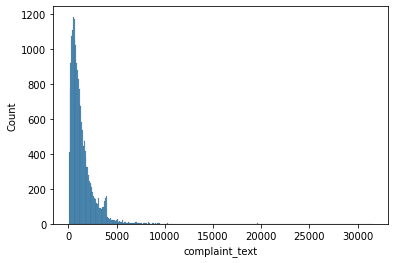

In [14]:
# Write your code here to visualise the data according to the 'Complaint' character length
sns.histplot(df_clean.complaint_text.apply(len))

#### Find the top 40 words by frequency among all the articles after processing the text.

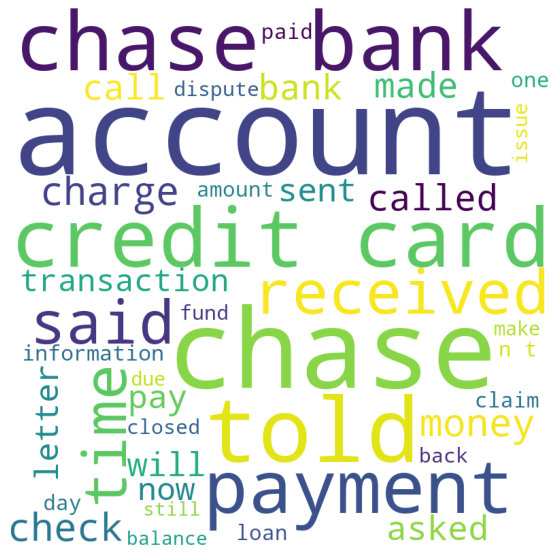

In [16]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud, STOPWORDS
xx_stopwords = ['x'*n for n in set([len(xx) for sent in df_clean.complaint_text.values for xx in re.findall('[x]+', sent)])]
stopwords = set(list(STOPWORDS) +xx_stopwords )

complaint_words = [word for sent in df_clean.complaint_text.values for word in sent.split()]

# complaint_words
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',max_words=40,
                stopwords = stopwords,
                min_font_size = 10).generate(" ".join(complaint_words))

plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [89]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_text'].str.replace('-PRON-', '')

/home/kantajit/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [33]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
from functools import reduce
import tqdm
complaint_words = [word for complaint in tqdm.tqdm(df_clean.Complaint_clean.values) for word in complaint.split() ]
complaint_words[:10]
clean_complaint_words = [x for x in complaint_words if x not in xx_stopwords]
from nltk import ngrams
n=1
unigrams = ngrams(clean_complaint_words, n)
unigram_freqs = nltk.FreqDist(unigrams)
print(unigram_freqs.most_common(30))

100%|██████████| 21072/21072 [00:00<00:00, 65936.33it/s]


[(('the',), 239108), (('i',), 196860), (('to',), 182019), (('and',), 145918), (('a',), 106792), (('my',), 106644), (('that',), 86506), (('chase',), 80734), (('was',), 79779), (('of',), 79238), (('on',), 63256), (('in',), 62658), (('they',), 56390), (('for',), 55377), (('me',), 51860), (('not',), 51574), (('this',), 47517), (('have',), 44762), (('with',), 43899), (('is',), 43536), (('account',), 42713), (('it',), 39296), (('credit',), 32789), (('00',), 30454), (('from',), 30340), (('card',), 26911), (('bank',), 26733), (('as',), 26623), (('had',), 26538), (('be',), 23353)]


In [34]:
#Print the top 10 words in the unigram frequency
print(unigram_freqs.most_common(10))

[(('the',), 239108), (('i',), 196860), (('to',), 182019), (('and',), 145918), (('a',), 106792), (('my',), 106644), (('that',), 86506), (('chase',), 80734), (('was',), 79779), (('of',), 79238)]


In [35]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
n=2
bigrams = ngrams(clean_complaint_words, n)
bigram_freqs = nltk.FreqDist(bigrams)
print(bigram_freqs.most_common(30))

[(('i', 'was'), 19981), (('i', 'have'), 19531), (('of', 'the'), 16897), (('that', 'i'), 15564), (('to', 'the'), 13629), (('my', 'account'), 12879), (('chase', 'bank'), 12589), (('in', 'the'), 12203), (('and', 'i'), 11695), (('on', 'the'), 11127), (('credit', 'card'), 10904), (('i', 'am'), 10618), (('my', 'credit'), 9949), (('i', 'had'), 9906), (('for', 'the'), 9562), (('on', 'my'), 9515), (('did', 'not'), 9065), (('that', 'the'), 8909), (('i', 'called'), 8145), (('it', 'was'), 7660), (('to', 'my'), 7618), (('with', 'the'), 7323), (('and', 'the'), 7246), (('to', 'be'), 7205), (('that', 'they'), 7094), (('the', 'account'), 6997), (('of', 'my'), 6954), (('and', 'they'), 6896), (('when', 'i'), 6512), (('for', 'a'), 6233)]


In [36]:
#Print the top 10 words in the bigram frequency
print(bigram_freqs.most_common(10))

[(('i', 'was'), 19981), (('i', 'have'), 19531), (('of', 'the'), 16897), (('that', 'i'), 15564), (('to', 'the'), 13629), (('my', 'account'), 12879), (('chase', 'bank'), 12589), (('in', 'the'), 12203), (('and', 'i'), 11695), (('on', 'the'), 11127)]


In [37]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
n=3
trigrams = ngrams(clean_complaint_words, n)
trigram_freqs = nltk.FreqDist(trigrams)
print(trigram_freqs.most_common(30))

[(('i', 'did', 'not'), 3599), (('i', 'was', 'told'), 3415), (('my', 'credit', 'report'), 2577), (('i', 'have', 'been'), 2537), (('i', 'received', 'a'), 2517), (('on', 'my', 'credit'), 2444), (('i', 'called', 'chase'), 2399), (('jp', 'morgan', 'chase'), 2208), (('my', 'credit', 'card'), 2157), (('told', 'me', 'that'), 2087), (('that', 'i', 'was'), 1930), (('the', 'amount', 'of'), 1891), (('chase', 'credit', 'card'), 1882), (('was', 'told', 'that'), 1835), (('that', 'i', 'had'), 1746), (('i', 'do', 'not'), 1694), (('on', 'my', 'account'), 1589), (('to', 'my', 'account'), 1556), (('i', 'have', 'a'), 1474), (('and', 'was', 'told'), 1473), (('i', 'had', 'to'), 1473), (('they', 'told', 'me'), 1410), (('with', 'chase', 'bank'), 1410), (('my', 'account', 'and'), 1409), (('the', 'credit', 'card'), 1379), (('my', 'checking', 'account'), 1347), (('and', 'i', 'have'), 1340), (('did', 'n', 't'), 1326), (('i', 'went', 'to'), 1324), (('on', 'the', 'phone'), 1322)]


In [38]:
#Print the top 10 words in the trigram frequency
print(trigram_freqs.most_common(10))

[(('i', 'did', 'not'), 3599), (('i', 'was', 'told'), 3415), (('my', 'credit', 'report'), 2577), (('i', 'have', 'been'), 2537), (('i', 'received', 'a'), 2517), (('on', 'my', 'credit'), 2444), (('i', 'called', 'chase'), 2399), (('jp', 'morgan', 'chase'), 2208), (('my', 'credit', 'card'), 2157), (('told', 'me', 'that'), 2087)]


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [90]:
for x_stop in xx_stopwords:
    df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace(x_stop,'')

/home/kantajit/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [91]:
#All masked texts has been removed
df_clean

,complaint_text,lemmatized_complaint,pos_tags,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,"[good, morning, my, name, is, xxxx, xxxx, and,...","[ADJ, NOUN, PRON, NOUN, AUX, NOUN, NOUN, CCONJ...",good morning my name is and i appreciate it ...
2,i upgraded my xxxx xxxx card in xx xx 2018 and...,"[i, upgraded, my, xxxx, xxxx, card, in, xx, xx...","[PRON, VERB, PRON, ADJ, ADJ, NOUN, ADP, PROPN,...",i upgraded my card in 2018 and was told by...
10,chase card was reported on xx xx 2019 however...,"[chase, card, wa, reported, on, xx, xx, 2019, ...","[PROPN, NOUN, AUX, VERB, ADP, PROPN, PROPN, NU...",chase card was reported on 2019 however fr...
11,on xx xx 2018 while trying to book a xxxx xx...,"[on, xx, xx, 2018, while, trying, to, book, a,...","[ADP, PROPN, PROPN, NUM, SPACE, SCONJ, VERB, P...",on 2018 while trying to book a ticket ...
14,my grand son give me check for 1600 00 i de...,"[my, grand, son, give, me, check, for, 1600, 0...","[PRON, ADJ, NOUN, VERB, PRON, NOUN, ADP, SPACE...",my grand son give me check for 1600 00 i de...
...,...,...,...,...
78303,after being a chase card customer for well ove...,"[after, being, a, chase, card, customer, for, ...","[ADP, AUX, DET, NOUN, NOUN, NOUN, ADP, ADV, AD...",after being a chase card customer for well ove...
78309,on wednesday xx xx xxxx i called chas my xxx...,"[on, wednesday, xx, xx, xxxx, i, called, chas,...","[ADP, PROPN, SPACE, PROPN, PROPN, PROPN, PRON,...",on wednesday i called chas my visa cred...
78310,i am not familiar with xxxx pay and did not un...,"[i, am, not, familiar, with, xxxx, pay, and, d...","[PRON, AUX, PART, ADJ, ADP, ADJ, NOUN, CCONJ, ...",i am not familiar with pay and did not unders...
78311,i have had flawless credit for 30 yrs i ve ha...,"[i, have, had, flawless, credit, for, 30, yr, ...","[PRON, AUX, VERB, ADJ, NOUN, ADP, NUM, NOUN, S...",i have had flawless credit for 30 yrs i ve ha...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [41]:
#Write your code here to initialise the TfidfVectorizer 
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_model = vectorizer.fit_transform(df_clean.Complaint_clean.values)
print(tfidf_model)

  (0, 1485)	0.1923248916865412
  (0, 24748)	0.19242701330324916
  (0, 1144)	0.05997438162764374
  (0, 6004)	0.13839969823652942
  (0, 13109)	0.09339161312576438
  (0, 14206)	0.10881792996153429
  (0, 21480)	0.13172267364851206
  (0, 5313)	0.18543717316234443
  (0, 2727)	0.19092310304650667
  (0, 16038)	0.11543624181557932
  (0, 15073)	0.12497356642200796
  (0, 19991)	0.15349787887628272
  (0, 13352)	0.14308207074908963
  (0, 26748)	0.22147257423286973
  (0, 1073)	0.22326211811734678
  (0, 23509)	0.12543201247915411
  (0, 22259)	0.09351461069182607
  (0, 26863)	0.18569356198447312
  (0, 6957)	0.4089486025554494
  (0, 2536)	0.286899346856158
  (0, 27786)	0.1739062237887583
  (0, 308)	0.15364597014644713
  (0, 22336)	0.1413221272673088
  (0, 4361)	0.22586801595604936
  (0, 3118)	0.13492506173336014
  :	:
  (21071, 14665)	0.07509763811814527
  (21071, 19978)	0.05406954091817565
  (21071, 27816)	0.21738922321683504
  (21071, 17859)	0.2503342101115581
  (21071, 5169)	0.2631534170671738
  (21

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [42]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
doc_term_matrix = pd.DataFrame(tfidf_model.toarray(), columns = vectorizer.get_feature_names())
doc_term_matrix.head()

,00,000,0000,0000000,001,003,003933,004,0073,01,...,zip,zipcode,zipped,zombie,zone,zoned,zones,zoo,zoom,zoomed
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.033585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.047317,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [43]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [44]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [45]:
nmf_model.fit(doc_term_matrix)
len(vectorizer.get_feature_names())

27909

In [46]:
#Print the Top15 words for each of the topics
W = nmf_model.transform(doc_term_matrix)  # Document-topic matrix
H = nmf_model.components_ 
words = np.array(vectorizer.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,bank,check,chase,money,funds,checking,closed,deposit,branch,told,accounts,00,deposited,said
Topic 2,credit,card,report,inquiry,chase,inquiries,cards,hard,reporting,score,accounts,account,removed,closed,debt
Topic 3,loan,mortgage,chase,home,modification,property,foreclosure,payments,house,sale,morgan,bank,years,letter,jp
Topic 4,card,chase,00,charges,charge,dispute,fraud,called,received,did,transaction,claim,merchant,told,refund
Topic 5,payment,late,payments,balance,00,paid,pay,fees,month,fee,statement,account,auto,monthly,charged


In [47]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_mapping = {
    'Topic 1': 'Bank Account',
    'Topic 2': 'Credit card',
    'Topic 3': 'Mortgage/Loan',
    'Topic 4': 'Theft/Dispute',
    'Topic 5': 'Others'
}

In [109]:
W.shape

(21072, 5)

In [110]:
W

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,0.020655,0.014028,0.027099,0.008750,0.003260
1,0.005791,0.006320,0.002919,0.015907,0.001739
2,0.000000,0.043979,0.000000,0.014419,0.000000
3,0.016831,0.048317,0.017239,0.030665,0.000000
4,0.059419,0.000000,0.002696,0.004713,0.001129
...,...,...,...,...,...
21067,0.000000,0.056708,0.000000,0.032328,0.021013
21068,0.003853,0.003365,0.008086,0.054903,0.000000
21069,0.014855,0.009407,0.009202,0.027148,0.000000
21070,0.000000,0.022210,0.002972,0.034022,0.084440


In [113]:
#Assign the best topic to each of the cmplaints in Topic Column
W = pd.DataFrame(W, columns=[f'Topic {i + 1}' for i in range(num_topics)])
W['Topic'] =W.apply(lambda x: topic_mapping.get(x.idxmax()), axis=1)

In [129]:
df_clean.reset_index(inplace=True, drop=True)

In [130]:
df_clean['Topic'] = W['Topic']

/home/kantajit/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [131]:
df_clean.head()

,complaint_text,lemmatized_complaint,pos_tags,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,"[good, morning, my, name, is, xxxx, xxxx, and,...","[ADJ, NOUN, PRON, NOUN, AUX, NOUN, NOUN, CCONJ...",good morning my name is and i appreciate it ...,Mortgage/Loan
1,i upgraded my xxxx xxxx card in xx xx 2018 and...,"[i, upgraded, my, xxxx, xxxx, card, in, xx, xx...","[PRON, VERB, PRON, ADJ, ADJ, NOUN, ADP, PROPN,...",i upgraded my card in 2018 and was told by...,Theft/Dispute
2,chase card was reported on xx xx 2019 however...,"[chase, card, wa, reported, on, xx, xx, 2019, ...","[PROPN, NOUN, AUX, VERB, ADP, PROPN, PROPN, NU...",chase card was reported on 2019 however fr...,Credit card
3,on xx xx 2018 while trying to book a xxxx xx...,"[on, xx, xx, 2018, while, trying, to, book, a,...","[ADP, PROPN, PROPN, NUM, SPACE, SCONJ, VERB, P...",on 2018 while trying to book a ticket ...,Credit card
4,my grand son give me check for 1600 00 i de...,"[my, grand, son, give, me, check, for, 1600, 0...","[PRON, ADJ, NOUN, VERB, PRON, NOUN, ADP, SPACE...",my grand son give me check for 1600 00 i de...,Bank Account


In [132]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21072 entries, 0 to 21071
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   complaint_text        21072 non-null  object
 1   lemmatized_complaint  21072 non-null  object
 2   pos_tags              21072 non-null  object
 3   Complaint_clean       21072 non-null  object
 4   Topic                 21072 non-null  object
dtypes: object(5)
memory usage: 823.2+ KB


In [133]:
#Print the first 5 Complaint for each of the Topics
df_clean_group=df_clean.groupby('Topic').head(5)
df_clean_group.sort_values('Topic')

,complaint_text,lemmatized_complaint,pos_tags,Complaint_clean,Topic
12,i opened an account with chase bank on xxxx an...,"[i, opened, an, account, with, chase, bank, on...","[PRON, VERB, DET, NOUN, ADP, PROPN, PROPN, ADP...",i opened an account with chase bank on and us...,Bank Account
4,my grand son give me check for 1600 00 i de...,"[my, grand, son, give, me, check, for, 1600, 0...","[PRON, ADJ, NOUN, VERB, PRON, NOUN, ADP, SPACE...",my grand son give me check for 1600 00 i de...,Bank Account
6,with out notice j p morgan chase restricted m...,"[with, out, notice, j, p, morgan, chase, restr...","[ADP, ADP, NOUN, DET, PROPN, SPACE, PROPN, PRO...",with out notice j p morgan chase restricted m...,Bank Account
10,mishandling of this account by chase auto and ...,"[mishandling, of, this, account, by, chase, au...","[VERB, ADP, DET, NOUN, ADP, PROPN, NOUN, CCONJ...",mishandling of this account by chase auto and,Bank Account
15,i opened the saving account for the 25 00 b...,"[i, opened, the, saving, account, for, the, 25...","[PRON, VERB, DET, NOUN, NOUN, ADP, DET, SPACE,...",i opened the saving account for the 25 00 b...,Bank Account
2,chase card was reported on xx xx 2019 however...,"[chase, card, wa, reported, on, xx, xx, 2019, ...","[PROPN, NOUN, AUX, VERB, ADP, PROPN, PROPN, NU...",chase card was reported on 2019 however fr...,Credit card
3,on xx xx 2018 while trying to book a xxxx xx...,"[on, xx, xx, 2018, while, trying, to, book, a,...","[ADP, PROPN, PROPN, NUM, SPACE, SCONJ, VERB, P...",on 2018 while trying to book a ticket ...,Credit card
5,can you please remove inquiry,"[can, you, please, remove, inquiry]","[AUX, PRON, INTJ, VERB, NOUN]",can you please remove inquiry,Credit card
9,i have a chase credit card which is incorrectl...,"[i, have, a, chase, credit, card, which, is, i...","[PRON, VERB, DET, NOUN, NOUN, NOUN, PRON, AUX,...",i have a chase credit card which is incorrectl...,Credit card
11,i have reached out to xxxx several times in at...,"[i, have, reached, out, to, xxxx, several, tim...","[PRON, AUX, VERB, ADP, PART, VERB, ADJ, NOUN, ...",i have reached out to several times in attemp...,Credit card


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [134]:
#Create the dictionary of Topic names and Topics

Topic_names = { 'Bank Account': 'Bank Account services',
    'Credit card': 'Credit card or prepaid card',
    'Mortgage/Loan': 'Mortgage/Loan',
    'Theft/Dispute': 'Theft/Dispute Reporting',
    'Others' : 'Others' }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

/home/kantajit/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [135]:
df_clean

,complaint_text,lemmatized_complaint,pos_tags,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,"[good, morning, my, name, is, xxxx, xxxx, and,...","[ADJ, NOUN, PRON, NOUN, AUX, NOUN, NOUN, CCONJ...",good morning my name is and i appreciate it ...,Mortgage/Loan
1,i upgraded my xxxx xxxx card in xx xx 2018 and...,"[i, upgraded, my, xxxx, xxxx, card, in, xx, xx...","[PRON, VERB, PRON, ADJ, ADJ, NOUN, ADP, PROPN,...",i upgraded my card in 2018 and was told by...,Theft/Dispute Reporting
2,chase card was reported on xx xx 2019 however...,"[chase, card, wa, reported, on, xx, xx, 2019, ...","[PROPN, NOUN, AUX, VERB, ADP, PROPN, PROPN, NU...",chase card was reported on 2019 however fr...,Credit card or prepaid card
3,on xx xx 2018 while trying to book a xxxx xx...,"[on, xx, xx, 2018, while, trying, to, book, a,...","[ADP, PROPN, PROPN, NUM, SPACE, SCONJ, VERB, P...",on 2018 while trying to book a ticket ...,Credit card or prepaid card
4,my grand son give me check for 1600 00 i de...,"[my, grand, son, give, me, check, for, 1600, 0...","[PRON, ADJ, NOUN, VERB, PRON, NOUN, ADP, SPACE...",my grand son give me check for 1600 00 i de...,Bank Account services
...,...,...,...,...,...
21067,after being a chase card customer for well ove...,"[after, being, a, chase, card, customer, for, ...","[ADP, AUX, DET, NOUN, NOUN, NOUN, ADP, ADV, AD...",after being a chase card customer for well ove...,Credit card or prepaid card
21068,on wednesday xx xx xxxx i called chas my xxx...,"[on, wednesday, xx, xx, xxxx, i, called, chas,...","[ADP, PROPN, SPACE, PROPN, PROPN, PROPN, PRON,...",on wednesday i called chas my visa cred...,Theft/Dispute Reporting
21069,i am not familiar with xxxx pay and did not un...,"[i, am, not, familiar, with, xxxx, pay, and, d...","[PRON, AUX, PART, ADJ, ADP, ADJ, NOUN, CCONJ, ...",i am not familiar with pay and did not unders...,Theft/Dispute Reporting
21070,i have had flawless credit for 30 yrs i ve ha...,"[i, have, had, flawless, credit, for, 30, yr, ...","[PRON, AUX, VERB, ADJ, NOUN, ADP, NUM, NOUN, S...",i have had flawless credit for 30 yrs i ve ha...,Others


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [136]:
#Create the dictionary again of Topic names and Topics

Topic_names = { 'Bank Account services':'Bank Account',
    'Credit card or prepaid card':'Credit card',
    'Mortgage/Loan':'Mortgage/Loan',
    'Theft/Dispute Reporting':'Theft/Dispute',
    'Others' : 'Others'  }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

/home/kantajit/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [137]:
df_clean

,complaint_text,lemmatized_complaint,pos_tags,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,"[good, morning, my, name, is, xxxx, xxxx, and,...","[ADJ, NOUN, PRON, NOUN, AUX, NOUN, NOUN, CCONJ...",good morning my name is and i appreciate it ...,Mortgage/Loan
1,i upgraded my xxxx xxxx card in xx xx 2018 and...,"[i, upgraded, my, xxxx, xxxx, card, in, xx, xx...","[PRON, VERB, PRON, ADJ, ADJ, NOUN, ADP, PROPN,...",i upgraded my card in 2018 and was told by...,Theft/Dispute
2,chase card was reported on xx xx 2019 however...,"[chase, card, wa, reported, on, xx, xx, 2019, ...","[PROPN, NOUN, AUX, VERB, ADP, PROPN, PROPN, NU...",chase card was reported on 2019 however fr...,Credit card
3,on xx xx 2018 while trying to book a xxxx xx...,"[on, xx, xx, 2018, while, trying, to, book, a,...","[ADP, PROPN, PROPN, NUM, SPACE, SCONJ, VERB, P...",on 2018 while trying to book a ticket ...,Credit card
4,my grand son give me check for 1600 00 i de...,"[my, grand, son, give, me, check, for, 1600, 0...","[PRON, ADJ, NOUN, VERB, PRON, NOUN, ADP, SPACE...",my grand son give me check for 1600 00 i de...,Bank Account
...,...,...,...,...,...
21067,after being a chase card customer for well ove...,"[after, being, a, chase, card, customer, for, ...","[ADP, AUX, DET, NOUN, NOUN, NOUN, ADP, ADV, AD...",after being a chase card customer for well ove...,Credit card
21068,on wednesday xx xx xxxx i called chas my xxx...,"[on, wednesday, xx, xx, xxxx, i, called, chas,...","[ADP, PROPN, SPACE, PROPN, PROPN, PROPN, PRON,...",on wednesday i called chas my visa cred...,Theft/Dispute
21069,i am not familiar with xxxx pay and did not un...,"[i, am, not, familiar, with, xxxx, pay, and, d...","[PRON, AUX, PART, ADJ, ADP, ADJ, NOUN, CCONJ, ...",i am not familiar with pay and did not unders...,Theft/Dispute
21070,i have had flawless credit for 30 yrs i ve ha...,"[i, have, had, flawless, credit, for, 30, yr, ...","[PRON, AUX, VERB, ADJ, NOUN, ADP, NUM, NOUN, S...",i have had flawless credit for 30 yrs i ve ha...,Others


In [138]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data= df_clean[['complaint_text', 'Topic']]

In [139]:
print(training_data.isna().sum())
training_data.dropna(inplace=True)

complaint_text    0
Topic             0
dtype: int64


/home/kantajit/tools/anaconda3/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [140]:
training_data

,complaint_text,Topic
0,good morning my name is xxxx xxxx and i apprec...,Mortgage/Loan
1,i upgraded my xxxx xxxx card in xx xx 2018 and...,Theft/Dispute
2,chase card was reported on xx xx 2019 however...,Credit card
3,on xx xx 2018 while trying to book a xxxx xx...,Credit card
4,my grand son give me check for 1600 00 i de...,Bank Account
...,...,...
21067,after being a chase card customer for well ove...,Credit card
21068,on wednesday xx xx xxxx i called chas my xxx...,Theft/Dispute
21069,i am not familiar with xxxx pay and did not un...,Theft/Dispute
21070,i have had flawless credit for 30 yrs i ve ha...,Others


In [141]:
training_data.shape

(21072, 2)

#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [142]:

#Write your code to get the Vector count
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(training_data.complaint_text.values).toarray()
X

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(training_data.complaint_text.values).toarray()
X

tfidf = vectorizer.fit_transform(training_data.complaint_text.values).toarray()
#Write your code here to transform the word vector to tf-idf


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [143]:
# Write your code here to build any 3 models and evaluate them using the required metrics
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(tfidf, training_data.Topic.values, test_size=0.33, random_state=40)


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


lrc = LogisticRegression().fit(X_train, y_train)

dtc =  DecisionTreeClassifier().fit(X_train, y_train)

rfc = RandomForestClassifier().fit(X_train, y_train)



/home/kantajit/tools/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [144]:
print(f'Accuracy on test data for LogisticRegression is {lrc.score(X_test, y_test)}')
print(f'Accuracy on test data for Decision Tree is {dtc.score(X_test, y_test)}')
print(f'Accuracy on test data for RandomForest is {rfc.score(X_test, y_test)}')


Accuracy on test data for LogisticRegression is 0.9499568593615185
Accuracy on test data for Decision Tree is 0.7579810181190682
Accuracy on test data for RandomForest is 0.8362093758987633
